In [1]:
%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.vision import *
from pathlib import Path
import PIL
import cv2

from utils import *

# from torch.utils.data.sampler import WeightedRandomSampler
from imba_sampler import ImbalancedDatasetSampler

torch.backends.cudnn.benchmark = False

In [2]:
MASKS = 'train.csv'

PATH = Path('./')
TRAIN = Path('train512/')
TEST = Path('test512/')
TRAIN_AUG = Path('../aug/train/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
seg_aug = pd.read_csv('../aug/augment.csv', header=None)
seg_aug.columns = seg.columns
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

classes = [str(l) for l in range(28)]

In [3]:
df = pd.read_csv('aug_train.csv'); len(df)

99165

# Resnet 18 style

In [4]:
arch = models.resnet18;

In [5]:
class ResLayer(nn.Module):
    "Resnet style `ResLayer`"
    def __init__(self, ni:int):
        "create ResLayer with `ni` inputs"
        super().__init__()
        self.conv1=conv_layer(ni, ni, ks=3)
        self.conv2=conv_layer(ni, ni, ks=3)

    def forward(self, x): return x + self.conv2(self.conv1(x))

class SEModule(nn.Module):
    def __init__(self, ch, re=16):
        super().__init__()
        self.se = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                 nn.Conv2d(ch,ch//re,1),
                                 nn.ReLU(inplace=True),
                                 nn.Conv2d(ch//re,ch,1),
                                 nn.Sigmoid()
                               )
    def forward(self, x):
        return x * self.se(x)
    
    
class ResLayerSE(nn.Module):
    "Resnet style `ResLayer`"
    def __init__(self, ni:int):
        "create ResLayer with `ni` inputs"
        super().__init__()
        self.conv1=conv_layer(ni, ni, ks=3)
        self.conv2=conv_layer(ni, ni, ks=1)
        
        #SE block
        self.SE = SEModule(ni)
        
    def forward(self, x): 
        return x + self.SE(self.conv2(self.conv1(x)))

In [6]:
def head(in_c, out):
    return nn.Sequential(ResLayerSE(in_c),
                         AdaptiveConcatPool2d(),
                         Flatten(),
                         nn.BatchNorm1d(2*in_c, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                         nn.Dropout(p=0.25),
                         nn.Linear(in_features=2*in_c, out_features=in_c, bias=True),
                         nn.ReLU(inplace=True),
                         nn.BatchNorm1d(in_c, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                         nn.Dropout(p=0.5),
                         nn.Linear(in_features=in_c, out_features=out, bias=True)
                        )

In [125]:
# R18 = nn.Sequential(
#     conv_layer(3, 64, ks=7, stride=2, padding=3),
#     ResLayer(64),
#     conv_layer(64, 128, ks=3, stride=2, padding=1),
#     ResLayer(128),
#     conv_layer(128, 256, ks=3, stride=2, padding=1),
#     ResLayer(256),
# #     conv_layer(256, 512, ks=3, stride=2, padding=1),
# #     ResLayerSE(512),
#     head(256, 28)
# )

# Load Body

In [126]:
state_dict_body = OrderedDict()
state_dict_head = OrderedDict()
state_dict = torch.load('models/r18_512_brian_u.pth')

In [127]:
state_dict['model'].keys()

odict_keys(['0.0.weight', '0.1.weight', '0.1.bias', '0.1.running_mean', '0.1.running_var', '0.1.num_batches_tracked', '0.4.0.conv1.weight', '0.4.0.bn1.weight', '0.4.0.bn1.bias', '0.4.0.bn1.running_mean', '0.4.0.bn1.running_var', '0.4.0.bn1.num_batches_tracked', '0.4.0.conv2.weight', '0.4.0.bn2.weight', '0.4.0.bn2.bias', '0.4.0.bn2.running_mean', '0.4.0.bn2.running_var', '0.4.0.bn2.num_batches_tracked', '0.4.1.conv1.weight', '0.4.1.bn1.weight', '0.4.1.bn1.bias', '0.4.1.bn1.running_mean', '0.4.1.bn1.running_var', '0.4.1.bn1.num_batches_tracked', '0.4.1.conv2.weight', '0.4.1.bn2.weight', '0.4.1.bn2.bias', '0.4.1.bn2.running_mean', '0.4.1.bn2.running_var', '0.4.1.bn2.num_batches_tracked', '0.5.0.conv1.weight', '0.5.0.bn1.weight', '0.5.0.bn1.bias', '0.5.0.bn1.running_mean', '0.5.0.bn1.running_var', '0.5.0.bn1.num_batches_tracked', '0.5.0.conv2.weight', '0.5.0.bn2.weight', '0.5.0.bn2.bias', '0.5.0.bn2.running_mean', '0.5.0.bn2.running_var', '0.5.0.bn2.num_batches_tracked', '0.5.0.downsample.

In [128]:
r18 = create_body(arch)

In [129]:
for k, v in state_dict['model'].items():
    
    if k[0]=='0':
        name = k[2:] 
        state_dict_body[name] = v
    else:
        state_dict_head[k] = v
        

In [130]:
r18.load_state_dict(state_dict_body)

# Load Head

In [131]:
state_dict_head.keys()

odict_keys(['1.2.weight', '1.2.bias', '1.2.running_mean', '1.2.running_var', '1.2.num_batches_tracked', '1.4.weight', '1.4.bias', '1.6.weight', '1.6.bias', '1.6.running_mean', '1.6.running_var', '1.6.num_batches_tracked', '1.8.weight', '1.8.bias'])

In [7]:
chead = head(512,28)

In [133]:
chead.state_dict().keys()

odict_keys(['0.conv1.0.weight', '0.conv1.2.weight', '0.conv1.2.bias', '0.conv1.2.running_mean', '0.conv1.2.running_var', '0.conv1.2.num_batches_tracked', '0.conv2.0.weight', '0.conv2.2.weight', '0.conv2.2.bias', '0.conv2.2.running_mean', '0.conv2.2.running_var', '0.conv2.2.num_batches_tracked', '0.SE.se.1.weight', '0.SE.se.1.bias', '0.SE.se.3.weight', '0.SE.se.3.bias', '3.weight', '3.bias', '3.running_mean', '3.running_var', '3.num_batches_tracked', '5.weight', '5.bias', '7.weight', '7.bias', '7.running_mean', '7.running_var', '7.num_batches_tracked', '9.weight', '9.bias'])

In [134]:
keys = list(chead.state_dict().keys())

In [135]:
se_keys = keys[:-14]

new_keys = keys[-14:]

old_keys = ['1.2.weight', '1.2.bias', '1.2.running_mean', '1.2.running_var', '1.2.num_batches_tracked', 
            '1.4.weight', '1.4.bias', '1.6.weight', '1.6.bias', '1.6.running_mean', '1.6.running_var', 
            '1.6.num_batches_tracked', '1.8.weight', '1.8.bias']

In [136]:
new_state_dict_head = OrderedDict()

for k in se_keys:
    new_state_dict_head[k]=chead.state_dict()[k]

for k1,k2 in zip(new_keys, old_keys):
    new_state_dict_head[k1]=state_dict_head[k2]



In [137]:
chead.load_state_dict(new_state_dict_head)

Model Defs

In [8]:
stats = ([0.08069, 0.05258, 0.05487], [0.13704,0.10145, 0.15313])
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_lighting=0.1, max_warp=0.4)

In [9]:
def get_data(sz=64, bs=64, pct=0.2, sample=5000):
#     sz, pct, bs = 64, 0.2, 64
    src = (ImageItemList.from_df(df=df, path=PATH, folder=TRAIN_AUG, suffix='.png')
           .random_split_by_pct(pct)
           .label_from_df(sep=' ', classes=classes)
           .add_test([TEST/(f+'.png') for f in test_names]))
    data = (src.transform(tfms, size=sz))
    #         .databunch(bs=bs).normalize(stats))

    test_ds = data.test
    train_ds, val_ds = data.train, data.valid
    datasets = [train_ds,val_ds, test_ds]
    sampler = ImbalancedDatasetSampler(datasets[0], num_samples=sample)
    train_dl = DataLoader(datasets[0], bs, sampler=sampler, num_workers=12)
    val_dl = DataLoader(datasets[1], 2*bs, False, num_workers=8)
    test_dl = DataLoader(datasets[2], 2*bs, False, num_workers=8)

    return ImageDataBunch(train_dl=train_dl, valid_dl=val_dl, test_dl=test_dl).normalize(stats)

In [10]:
def get_learner(data, focal=False, fp16=False):
    learn = create_cnn(data, arch, custom_head = chead, metrics=[accuracy_thresh, f1], 
               callback_fns=[partial(GradientClipping, clip=0.1), ShowGraph])
    if focal: learn.loss_func = FocalLoss()
    if fp16: learn.to_fp16();
#     learn.split((arch.layers[9],arch.layers[13]))  #Split for 444 model [11,20]
    return learn.mixup(stack_y=False)

# 256

In [141]:
data = get_data(256, 128, 0.1, sample=None)

In [142]:
learn = get_learner(data, focal=True, fp16=True)

In [143]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


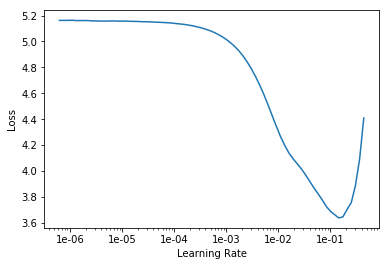

In [144]:
learn.recorder.plot()

In [145]:
lr = 1e-2

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,1.099243,0.934816,0.959254,0.189289
2,0.945128,0.862481,0.962770,0.279160
3,0.881749,0.817537,0.963954,0.291478


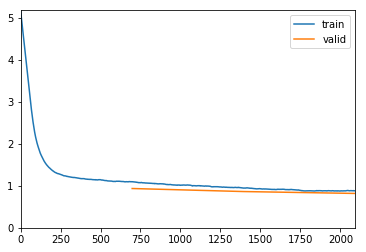

CPU times: user 13min 37s, sys: 5min 21s, total: 18min 58s
Wall time: 20min 9s


In [147]:
%time learn.fit_one_cycle(3, slice(lr))

In [148]:
learn.save('r18C_256');

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,0.894119,0.826192,0.963645,0.285123
2,0.907086,0.899927,0.961847,0.278555
3,0.889532,0.831060,0.963508,0.320659
4,0.821463,0.800053,0.963965,0.338091
5,0.780307,0.759781,0.966418,0.360099
6,0.760441,0.758117,0.966429,0.365276


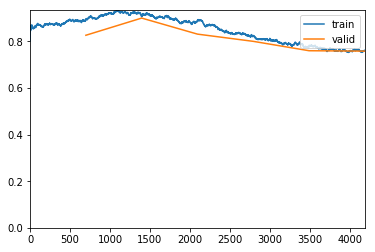

CPU times: user 27min 10s, sys: 10min 42s, total: 37min 52s
Wall time: 40min 16s


In [149]:
%time learn.fit_one_cycle(6, slice(lr))

In [150]:
learn.save('r18C_256');

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,0.894410,0.945821,0.960951,0.255605
2,0.854074,0.905605,0.960356,0.280369
3,0.745612,0.706355,0.968276,0.400595
4,0.664962,0.680807,0.969000,0.429212
5,0.599460,0.580317,0.973268,0.496339
6,0.578803,0.565739,0.973679,0.501856


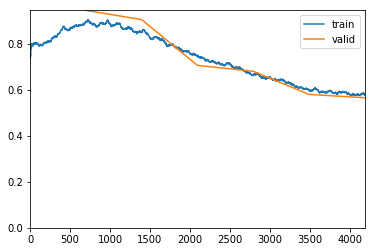

CPU times: user 33min, sys: 13min 57s, total: 46min 57s
Wall time: 48min 51s


In [ ]:
%time learn.fit_one_cycle(6, slice(lr/10,lr/3))

In [ ]:
learn.save('r18C_256_u');

# 512

In [11]:
data = get_data(512, 32, 0.01, sample=None)

In [12]:
learn = get_learner(data, focal=True, fp16=True)

In [15]:
learn.load('r18C_256_u');

In [16]:
lr = 1e-2

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,0.711917,0.628798,0.970701,0.354332
2,0.655771,0.598372,0.972467,0.379441


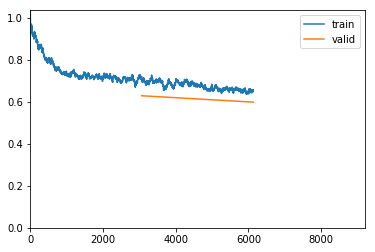

In [ ]:
%time learn.fit_one_cycle(3, slice(lr/3))

In [ ]:
learn.save('r18C_512')

In [17]:
learn.load('r18C_512'); lr=1e-2

In [21]:
learn.unfreeze()

In [ ]:
%time learn.fit_one_cycle(8, slice(lr/10,lr/3))

epoch,train_loss,valid_loss,accuracy_thresh,f1


In [20]:
learn.save('r18C_512_u');

In [31]:
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

# Sub File

In [32]:
model_name = 'r18c'

In [33]:
preds = to_np(p.sigmoid())  #Check if we are using focal loss or BCE.
threshold = 0.4 #ths
print(preds.shape)
classes = np.array(data.classes)
res = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds])

(11702, 28)


In [34]:
preds = to_np(p.sigmoid())  #Check if we are using focal loss or BCE.
np.save(model_name, preds)

In [35]:
frame = pd.DataFrame(np.array([test_names, res]).T, columns = ['Id','Predicted'])
frame.to_csv(f'{model_name}.csv', index=False)

In [36]:
frame.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 18 21 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 17 18 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,7 20


In [37]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f "r18c.csv" -m "custom R18"

100%|█████████████████████████████████████████| 484k/484k [00:01<00:00, 315kB/s]
Successfully submitted to Human Protein Atlas Image Classification